#Task 7

In [1]:
# Install SWIG, a tool used to connect C/C++ code with Python. It's often used in RL environments to enable efficient communication between Python and low-level implementations of algorithms
!pip install -q swig

# Install the gym library with the box2d environment, used for 2D physics-based simulation tasks
!pip install -q gym[box2d]

# Install stable-baselines3 with extra dependencies (needed for various environments and features in the library), a set of RL algorithms implemented in PyTorch
!pip install stable-baselines3[extra]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cac

In [2]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.dqn import MlpPolicy
import numpy as np

In [3]:
from stable_baselines3.common.callbacks import BaseCallback

# Create a custom callback class that will log the rewards at each episode
class RewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.rewards = []
        self.episode_rewards = []

    def _on_step(self) -> bool:
        # Collect rewards at each step
        reward = self.locals['rewards'][0]
        self.episode_rewards.append(reward)

        if self.locals['dones'][0]:  # Check if an episode is done
            episode_reward = sum(self.episode_rewards)
            self.rewards.append(episode_reward)
            self.episode_rewards = []  # Reset episode rewards for the next episode
            print(f"Episode: {len(self.rewards)}, Reward: {episode_reward}")

        return True

In [4]:
# Define a custom wrapper class that inherits from gym.Wrapper
class NormalizeActionWrapper(gym.Wrapper):
    """
    :param env: (gym.Env) Gym environment that will be wrapped
    """
    def __init__(self, env):
        """
        Initialize the wrapper.
        :param env: The environment to wrap.
        """
        # Retrieve the action space
        action_space = env.action_space
        assert isinstance(action_space, gym.spaces.Box), "This wrapper only works with continuous action space (spaces.Box)"

        # Retrieve the max/min values
        self.low, self.high = action_space.low, action_space.high

        # We modify the action space, so all actions will lie in [-1, 1]
        env.action_space = gym.spaces.Box(low=-1, high=1, shape=action_space.shape, dtype=np.float32)

        # Call the parent constructor, so we can access self.env later
        super(NormalizeActionWrapper, self).__init__(env)

    def rescale_action(self, scaled_action):
        """
        Rescale the action from [-1, 1] to [low, high]
        (no need for symmetric action space)
        :param scaled_action: (np.ndarray) The action to rescale
        :return: (np.ndarray) The rescaled action
        """
        return self.low + 0.5 * (scaled_action + 1.0) * (self.high - self.low)

    def reset(self, **kwargs):
        """
        Reset the environment.
        :param kwargs: Additional arguments for the reset method.
        :return: Initial observation and info after reset.
        """
        return self.env.reset(**kwargs)

    def step(self, action):
        """
        Step the environment with the given action.
        :param action: (float or int) Action taken by the agent.
        :return: Tuple containing observation, reward, terminated, truncated, and info.
                 - obs: The next observation.
                 - reward: The reward received from the environment.
                 - terminated: Whether the episode has terminated.
                 - truncated: Whether the episode was truncated (e.g., max steps reached).
                 - info: Additional information.
        """
        # Rescale the action from [-1, 1] to the original [low, high] interval
        rescaled_action = self.rescale_action(action)
        # Take a step in the wrapped environment
        obs, reward, terminated, truncated, info = self.env.step(rescaled_action)
        return obs, reward, terminated, truncated, info

In [6]:
from stable_baselines3.common.vec_env import DummyVecEnv

# Without normalization
env = gym.make("Pendulum-v1")
env = DummyVecEnv([lambda: env])
model = PPO("MlpPolicy", env, verbose=1)
reward_callback = RewardCallback()
model.learn(total_timesteps=10000, callback=reward_callback)
rewards_without_norm = reward_callback.rewards

# With normalization
env = gym.make("Pendulum-v1")
env = NormalizeActionWrapper(env)
env = DummyVecEnv([lambda: env])
model = PPO("MlpPolicy", env, verbose=1)
reward_callback = RewardCallback()
model.learn(total_timesteps=10000, callback=reward_callback)
rewards_with_norm = reward_callback.rewards

Using cpu device
Episode: 1, Reward: -1163.644070982933
Episode: 2, Reward: -1069.5646753311157
Episode: 3, Reward: -1528.4361934661865
Episode: 4, Reward: -1657.8832502365112
Episode: 5, Reward: -1470.3932137489319
Episode: 6, Reward: -941.2282237261534
Episode: 7, Reward: -878.5695229098201
Episode: 8, Reward: -1015.7543888390064
Episode: 9, Reward: -1169.0795706510544
Episode: 10, Reward: -1687.5759143829346
-----------------------------
| time/              |      |
|    fps             | 1315 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
Episode: 11, Reward: -767.0049616107717
Episode: 12, Reward: -851.2705342844129
Episode: 13, Reward: -1456.0565326213837
Episode: 14, Reward: -1511.9900336265564
Episode: 15, Reward: -1554.3937816619873
Episode: 16, Reward: -1318.7154930830002
Episode: 17, Reward: -1172.2810916900635
Episode: 18, Reward: -965.3251231145114
Episode: 19, Reward: -1166.1260259151459
Episode: 

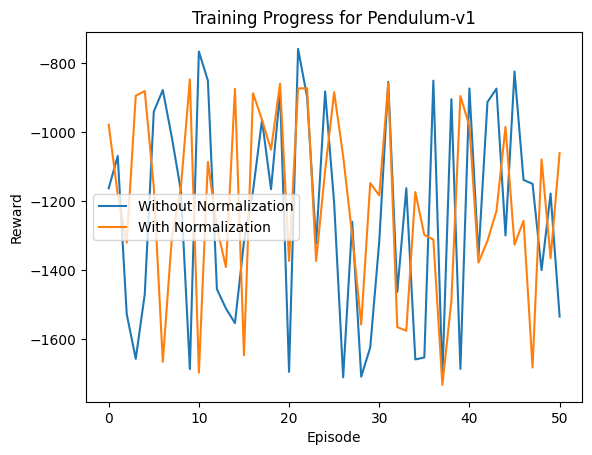

In [7]:
import matplotlib.pyplot as plt

# Plot results
plt.figure()
plt.plot(rewards_without_norm, label='Without Normalization')
plt.plot(rewards_with_norm, label='With Normalization')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress for Pendulum-v1')
plt.legend()
plt.show()